In [3]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

In [5]:
datasets = tf.keras.preprocessing.image_dataset_from_directory("dataset",
                                                               seed=123,
                                                               shuffle=True,
                                                               image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                               batch_size=BATCH_SIZE)

Found 8847 files belonging to 18 classes.
Metal device set to: Apple M1


In [6]:
datasets.class_names

['burgers',
 'chicken biriyani',
 'chicken pakoda',
 'chicken roll',
 'chicken tandori',
 'chiken curry',
 'chole bhature ',
 'dal fry',
 'dosa',
 'egg curry',
 'fish curry',
 'noodles',
 'paneer curry',
 'pizza',
 'prawn curry',
 'rice',
 'samosa',
 'vada pav']

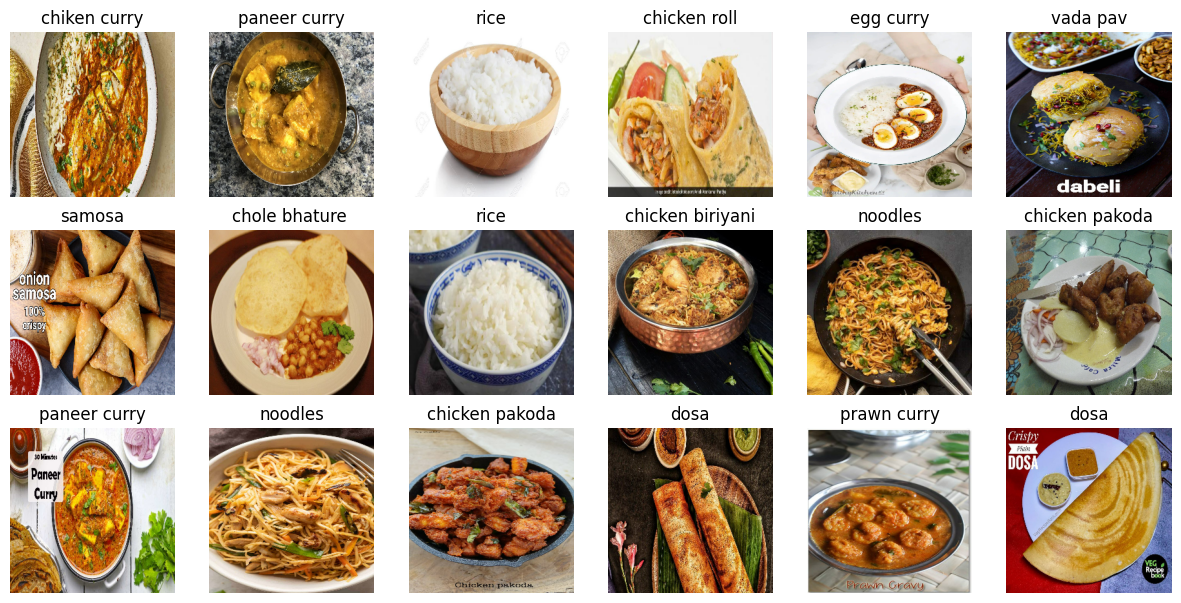

In [7]:
plt.figure(figsize=(15,15))
for image_batch , labels_batch in datasets.take(1):
    for i in range(18):
        ax = plt.subplot(6,6,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(datasets.class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split, val_split, test_split, shuffle, shuffle_size):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(
    datasets,
    train_split=0.8,
    val_split=0.1,
    test_split=0.1,
    shuffle=True,
    shuffle_size=len(datasets)
)

In [10]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
    
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.4),
   
])

In [13]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 18
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    
)

In [ ]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
221/221 [==============================] - 130s 448ms/step - loss: 2.8300 - accuracy: 0.0883 - val_loss: 2.6903 - val_accuracy: 0.1296
Epoch 2/100
221/221 [==============================] - 69s 309ms/step - loss: 2.6799 - accuracy: 0.1249 - val_loss: 2.5798 - val_accuracy: 0.1748
Epoch 3/100
221/221 [==============================] - 66s 296ms/step - loss: 2.6070 - accuracy: 0.1430 - val_loss: 2.5723 - val_accuracy: 0.1389
Epoch 4/100
221/221 [==============================] - 59s 267ms/step - loss: 2.5751 - accuracy: 0.1518 - val_loss: 2.5476 - val_accuracy: 0.1644
Epoch 5/100
221/221 [==============================] - 57s 255ms/step - loss: 2.5304 - accuracy: 0.1603 - val_loss: 2.5855 - val_accuracy: 0.1586
Epoch 6/100
221/221 [==============================] - 65s 292ms/step - loss: 2.4861 - accuracy: 0.1680 - val_loss: 2.4790 - val_accuracy: 0.1817
Epoch 7/100
221/221 [==============================] - 67s 302ms/step - loss: 2.4512 - accuracy: 0.1898 - val_loss: 2.4364 

Epoch 57/100
221/221 [==============================] - 64s 288ms/step - loss: 1.0154 - accuracy: 0.6600 - val_loss: 1.1789 - val_accuracy: 0.6019
Epoch 58/100
221/221 [==============================] - 65s 295ms/step - loss: 1.0092 - accuracy: 0.6632 - val_loss: 1.1510 - val_accuracy: 0.6215
Epoch 59/100
221/221 [==============================] - 71s 322ms/step - loss: 1.0131 - accuracy: 0.6611 - val_loss: 1.2711 - val_accuracy: 0.5845
Epoch 60/100
221/221 [==============================] - 67s 302ms/step - loss: 1.0131 - accuracy: 0.6615 - val_loss: 1.1668 - val_accuracy: 0.6111
Epoch 61/100
221/221 [==============================] - 69s 314ms/step - loss: 1.0116 - accuracy: 0.6649 - val_loss: 1.1517 - val_accuracy: 0.6019
Epoch 62/100
221/221 [==============================] - 68s 309ms/step - loss: 0.9754 - accuracy: 0.6685 - val_loss: 1.2234 - val_accuracy: 0.5880
Epoch 63/100
221/221 [==============================] - 65s 291ms/step - loss: 1.0048 - accuracy: 0.6600 - val_loss: 1